# DBSCAN Paralelo para deteccón de ruido

Mateo De La Roche - 190748

Bruno Molina Zacatenco - 187228

El algoritmo dbscan permite encontrar clusters o cúmulos y detectar ruido en un conjunto de puntos. Los únicos parámetros que necesita son epsilon y minPts. El primero es la distancia máxima entre dos puntos para que sean considerados vecinos y el segundo es el número mínimo de puntos que debe tener un vecindario para ser considerado un cluster.
Para este proyecto se implemento un "naive" dbscan ya que solo se encarga de encontrar el ruido y no de distinguir entre clusters. 

El objetivo del proyecto es comparar como mejora la eficiencia al paralelizar el algoritmo y ver como cambia según el número de hilos y el tamaño del dataset. Para hacer más facíl la generación se nos proporcióno el siguiento código:


In [54]:
from sklearn.datasets import make_blobs
import numpy as np

def points_generator(n_points):
    # randomly generating data points and noise 
    points, y_true = make_blobs(n_samples=n_points, 
                                centers=4, 
                                cluster_std=0.06, 
                                random_state=11, 
                                center_box=(0, 1.0))

    # only positive points and with three decimals
    points = np.round(np.abs(points[:, ::-1]), 3)

    # storing points into a csv file
    np.savetxt("data/"+str(n_points)+"_data.csv", points, delimiter=",",  fmt="%.3f")


Al tener los puntos generados, se implementó una version serial y una paralela.

Antes de pasar a las implementaciónes, para la distancia de los vecinos se utilizo la distancia euclidiana, calculada con la siguiente función:
```c++
float distance(float x1, float y1, float x2, float y2)
{   
    return sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2));
}
```

Cabe mencionar que se nos proporcionaron funciónes para cargar el csv y para guardar el resultado. Para tener un mejor orden en los archivos, se les hicieron unas modificaciones para separar los datasets y los resultados en diferentes carpetas. 

La función para cargar el csv recibe un arreglo de dos columanas de floats (fue generado con la función de arriba), el nombre del archivo y la cantidad de puntos. 
```c++	
void load_CSV(string file_name, float** points, long long int size) {
    ifstream in("data/"+file_name);
    if (!in) {
        cerr << "Couldn't read file: " << file_name << "\n";
    }
    long long int point_number = 0; 
    while (!in.eof() && (point_number < size)) {
        char* line = new char[12];
        streamsize row_size = 12;
        in.read(line, row_size);
        string row = line;
        //cout << stof(row.substr(0, 5)) << " - " << stof(row.substr(6, 5)) << "\n";
        points[point_number][0] = stof(row.substr(0, 5));
        points[point_number][1] = stof(row.substr(6, 5));
        point_number++;
    }
}
```

La función para guardar el resultado recibe los mismos parámetros que la función de cargar el csv, la única diferencia es que ahora el arreglo de dos columnas tiene un tercer elemento que indica si el punto es ruido o no. 

```c++	
//convierte la matriz de points en un archivo csv
void save_to_CSV(string file_name, float** points, long long int size) {
    fstream fout;
    fout.open("dump/"+file_name, ios::out);
    for (long long int i = 0; i < size; i++) {
        fout << points[i][0] << ","
             << points[i][1] << ","
             << points[i][2] << "\n";
    }
}
```

El main de las dos implementaciónes es prácticamente el mismo, solo cambia que para la version paralelizadas se le pasa el numero de hilos o threads como argumento y en el output se agrega el numero de hilos. El el siguiente código se encuentre comentado el output de la version paralelizada ya que es el main de la version serial.
  
```c++
int main(int argc, char** argv) {

    const float epsilon = 0.03;
    const int min_samples = 10;

    const long long int size = atoi(argv[1]);

    const string input_file_name = to_string(size)+"_data.csv";
    const string output_file_name = to_string(size)+"serial_results.csv";    
    float** points = new float*[size];
    double start = 0;
    double end = 0;


    for(long long int i = 0; i < size; i++) {
        points[i] = new float[3]{0.0, 0.0, 0.0}; 
        // index 0: position x
        // index 1: position y 
        // index 2: 0 for noise point, 1 for core point
    }

    load_CSV(input_file_name, points, size);
        
    start = omp_get_wtime();
    noise_detection(points, epsilon, min_samples, size); 
    end = omp_get_wtime();

    //datos, modo, hilos, tiempo
    cout << size << ",serial,1," << end - start << "\n";
    // cout << size << ",parallel," << num_threads << "," << end - start << "\n";

    save_to_CSV(output_file_name, points, size);


    for(long long int i = 0; i < size; i++) {
        delete[] points[i];
    }
    delete[] points;
    return 0;
}
```

## Ejecución de código	

In [55]:
#librerias que se utilizaran tanto en la ejecución del código como en la experimentación
import os
from matplotlib import interactive
from sklearn.cluster import DBSCAN
import pandas as pd
import plotly.express as px
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt


import plotly.io as pio
pio.renderers.default = "notebook_connected"

# para mostrar las gráficas en el repo es necesario que no sean interactivas
# se pueden ver en el notebook de manera interactiva, solo hay que cambiar el valor de la variable a True
interactive_graphs = False


Si descargó los ejecutables del proyecto, solo es necesario establecer los siguientes parámetros, generar los puntos y copiar el comando en la terminal (hay que modificar los parámetros en caso de que se hayan modificado las variables). Si no, puede compilar el código, para ello se necesita tener instalado el compilador de c++ y la librería openmp.
Para ahorrar tiempo, no se ejecutaran todas las pruebas que se realizaron en el proyecto, solo se realizaran las pruebas con 20000 puntos.

In [56]:
#en caso de que se quiera generar correr el código con otro número de puntos solo hace falta cambiar la variable n_points
n_points = 20000
hilos = 16

In [57]:
#points_generator(n_points)
#para correr el código solo hace falta correr en la terminal el comando que genera esta celda
print(f".\dbscan_noise_param.bat {n_points} {hilos}")

.\dbscan_noise_param.bat 20000 16


## Resultados
Solo se desplegan los resultados del dataset de 20000 puntos, para ver los resultados de los otros datasets, puede correr el código cambiando n_points. 
Asimismo solo se muestra un gráfico de las cuatro pruebas paralelizadas ya que los resultados son los mismos sin importar el número de hilos.
Primero se muestra el resultado obtenido utilizando la librería de sklearn, luego los resultados obtenidos con la implementación serial y por último los resultados obtenidos con la implementación paralelizada.

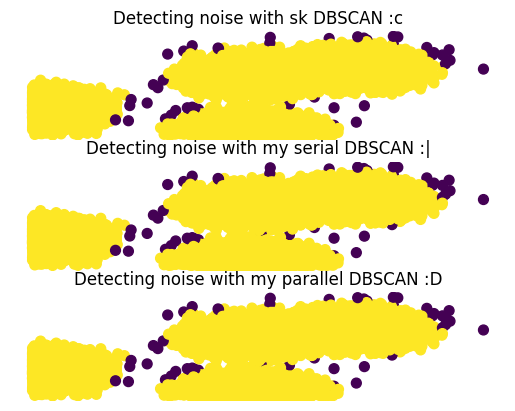

In [58]:
points = np.loadtxt("data/"+str(n_points)+"_data.csv", delimiter=",")
clusters = DBSCAN(eps=0.03, min_samples=10).fit_predict(points)

# plotting noise
plt.subplot(3, 1, 1)
plt.title("Detecting noise with sk DBSCAN :c")
plt.scatter(points[:, 0], points[:, 1], c=np.where(clusters==-1, 0, 1), s=50)
plt.xticks([])
plt.yticks([])
plt.box(False)


# loading results from c++ program into a numpy array
result_s = np.loadtxt(f"dump/{str(n_points)}_serial_results.csv", delimiter=",")

# plotting noise
plt.subplot(3, 1, 2)
plt.title("Detecting noise with my serial DBSCAN :|")
plt.scatter(result_s.T[0], result_s.T[1], c=result_s.T[2], s=50)
plt.xticks([])
plt.yticks([])
plt.box(False)

# loading results from c++ program into a numpy array
result_p = np.loadtxt(f"dump/{str(n_points)}p_{str(hilos)}n_results.csv", delimiter=",")

# plotting noise
plt.subplot(3, 1, 3)
plt.title("Detecting noise with my parallel DBSCAN :D")
plt.scatter(result_p.T[0], result_p.T[1], c=result_p.T[2], s=50)
plt.xticks([])
plt.yticks([])
plt.box(False)

plt.show()

En los puntos hay veces que unos poco que salen diferentes a como sale en sk-learn, esto se debe a la forma en la que se redondean los decimales y a como hacen las comparaciones en las diferentes implementciones.

## Experimentación
En la experimentación si se ejecutaron todas las pruebas.

In [59]:
#ya que hubo un problema con el guradado de resultados en la computadora de 16 hilos, hay que cargar los resultados de la ejecución de 12
#sin embargo usualmente no deberíamos correr esta celda

hilos = 12

In [60]:
#leemos las mediciones de tiempo y les agregamos headers 
df = pd.read_csv("dbscan_noise_res2.csv", names=['datos', 'modo', 'hilos', 'tiempo'])
#ya que cada ejecución se realiza tres veces, se promedian los tiempos
df = df.groupby(['datos', 'modo', 'hilos']).mean().reset_index()
df

,datos,modo,hilos,tiempo
0,20000,parallel,1,16.729000
1,20000,parallel,6,2.932333
2,20000,parallel,12,2.349000
3,20000,parallel,24,2.349000
4,20000,serial,1,16.510667
5,40000,parallel,1,66.999333
6,40000,parallel,6,11.479000
7,40000,parallel,12,9.374667
8,40000,parallel,24,9.463333
9,40000,serial,1,66.364667


In [61]:
#este dataframe se utilizara más adelante para el speedup pero es necesario sacarlo antes de que se modifique el dataframe
df_s = df[df.modo == 'serial']
df_s = df_s.append([df_s]*3, ignore_index=True)
df_s.sort_values(by=['datos'], inplace=True)
df_s.reset_index(inplace=True)

C:\Users\mateo\AppData\Local\Temp\ipykernel_22216\1777683934.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [62]:
#tanto el número de puntos como el número de hilos se convierten en variables categoricas
df.datos = df.datos.astype(str)
df.hilos = df.hilos.astype(str)

#por motivos estéticos separamos el dataframe en dos para poder graficarlos por separado
df_1 = df.loc[df['datos'].isin(['20000','40000','80000','120000'])]
df_2 = df.loc[~df['datos'].isin(['20000','40000','80000','120000'])]

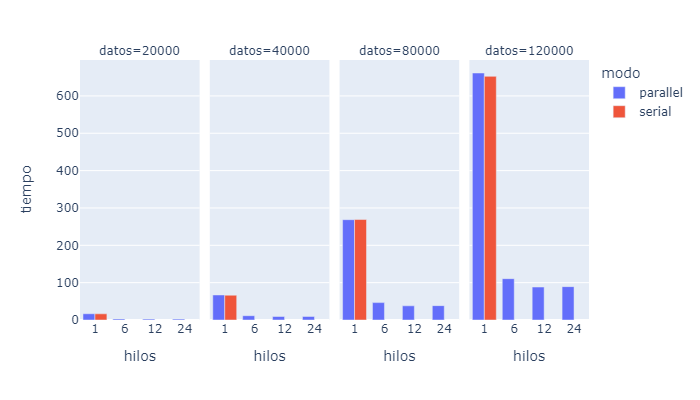

In [63]:
fig = px.bar(df_1, x="hilos", y="tiempo",
             color='modo', barmode='group',
             facet_col="datos",
             height=400)
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':['1',str(int(hilos/2)), str(hilos),str(hilos*2)]})

if interactive_graphs:
    fig.show()
else:
    fig.show("png")

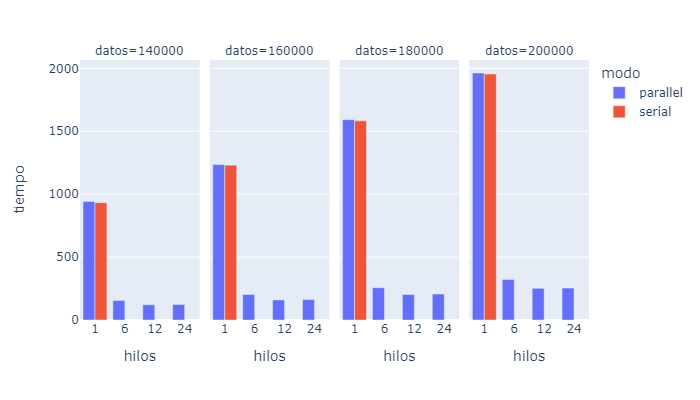

In [64]:
fig = px.bar(df_2, x="hilos", y="tiempo",
             color='modo', barmode='group',
             facet_col="datos",
             height=400)
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':['1',str(int(hilos/2)), str(hilos),str(hilos*2)]})

if interactive_graphs:
    fig.show()
else:
    fig.show("png")

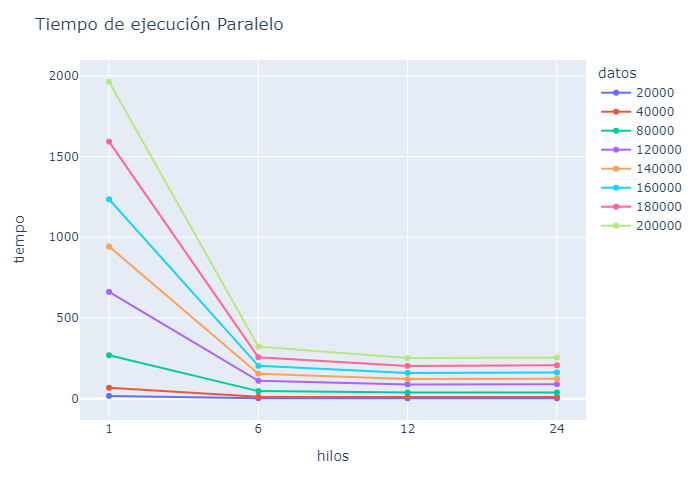

In [65]:
df_p = df[df.modo == "parallel"]
fig = px.line(df_p, x='hilos', y='tiempo', color='datos', markers=True)
fig.update_layout(title='Tiempo de ejecución Paralelo',
                   xaxis_title='hilos',
                   yaxis_title='tiempo')
fig.show("png")

In [66]:
df_p.reset_index(inplace=True)
df_p['speedup'] = df_s.tiempo / df_p.tiempo
df_p

C:\Users\mateo\AppData\Local\Temp\ipykernel_22216\692831269.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,index,datos,modo,hilos,tiempo,speedup
0,0,20000,parallel,1,16.729000,0.986949
1,1,20000,parallel,6,2.932333,5.630556
2,2,20000,parallel,12,2.349000,7.028807
3,3,20000,parallel,24,2.349000,7.028807
4,5,40000,parallel,1,66.999333,0.990527
5,6,40000,parallel,6,11.479000,5.781398
6,7,40000,parallel,12,9.374667,7.079149
7,8,40000,parallel,24,9.463333,7.012821
8,10,80000,parallel,1,268.620667,1.001616
9,11,80000,parallel,6,46.542000,5.780900


In [67]:
#speedup más alto conseguido
df_p[df_p.speedup == df_p.speedup.max()]

,index,datos,modo,hilos,tiempo,speedup
26,32,180000,parallel,12,202.549667,7.81461


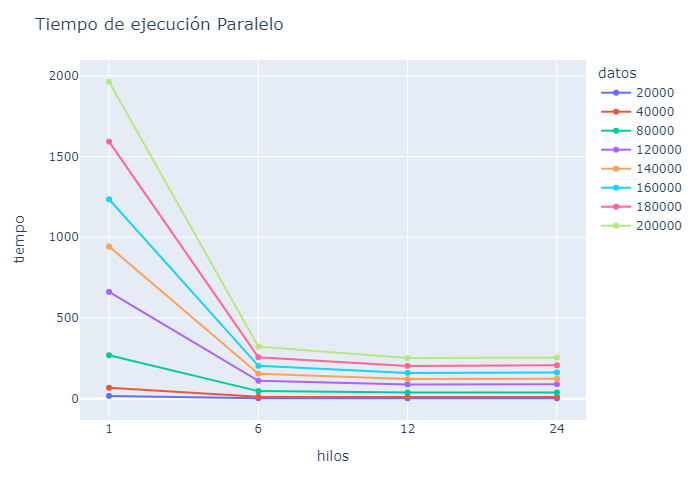

In [68]:
fig_sp = px.line(df_p, x='hilos', y='speedup', color='datos', markers=True)
fig_sp.update_layout(title='Speedups',
                   xaxis_title='hilos',
                   yaxis_title='speedup')

if interactive_graphs:
    fig.show()
else:
    fig.show("png")

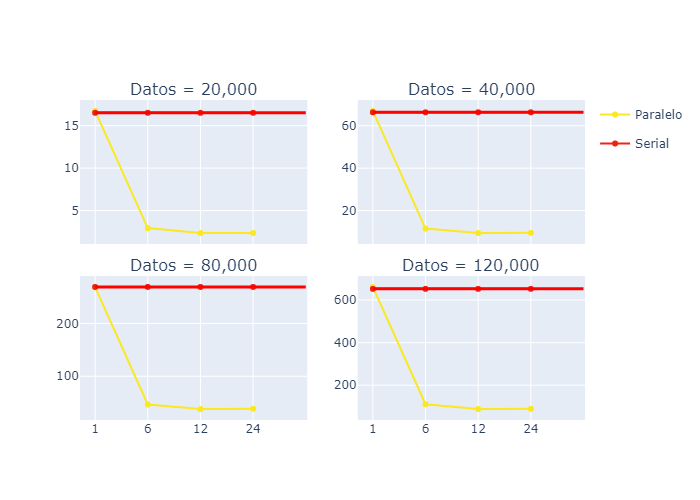

In [69]:
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.1,
                    horizontal_spacing=0.1, shared_xaxes=True, shared_yaxes=False,subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4"))
hilos_arr = df['hilos'].unique().tolist()

fig.add_trace(go.Scatter(x=hilos_arr, y=df.loc[(df['modo'] != 'serial') & (df['datos'] == "20000")].sort_index()['tiempo'], 
                         line_color='#fae823', showlegend=False,
                         hovertemplate=[], xaxis='x1', yaxis='y1',legendgroup = '1',name='Paralelo'), row=1, col=1)

fig.add_trace(go.Scatter(x=hilos_arr, y=df.loc[(df['modo'] != 'serial') & (df['datos'] == "40000")].sort_index()['tiempo'],
                         line_color='#fae823', showlegend=False,
                         hovertemplate=[], xaxis='x2', yaxis='y2',legendgroup = '1',name='Paralelo'), row=1, col=2)

fig.add_trace(go.Scatter(x=hilos_arr, y=df.loc[(df['modo'] != 'serial') & (df['datos'] == "80000")].sort_index()['tiempo'], 
                         line_color='#fae823', showlegend=True,
                         hovertemplate=[], xaxis='x3', yaxis='y3',legendgroup = '1',name='Paralelo'), row=2, col=1)

fig.add_trace(go.Scatter(x=hilos_arr, y=df.loc[(df['modo'] != 'serial') & (df['datos'] == "120000")].sort_index()['tiempo'],
                         line_color='#fae823', showlegend=False,
                         hovertemplate=[], xaxis='x4', yaxis='y4',legendgroup = '1',name='Paralelo'), row=2, col=2)

lista = ['20000','40000','80000','120000']
cont = 0
for i in range(2):
    for j in range(2):
            dt = df.loc[(df['modo'] == 'serial') & (df['datos'] == lista[cont])].sort_index()['tiempo'].sum()
            cont += 1
            if cont == 1:
                fig.add_trace(go.Scatter(x=hilos_arr, y=[dt,dt,dt,dt],
                         line_color='#EE2313', showlegend=True,
                         hovertemplate=[], xaxis='x' + str(cont), yaxis='y' + str(cont),legendgroup = '2',name='Serial'), row=i+1, col=j+1)
            else:
                fig.add_trace(go.Scatter(x=hilos_arr, y=[dt,dt,dt,dt],
                         line_color='#EE2313', showlegend=False,
                         hovertemplate=[], xaxis='x' + str(cont), yaxis='y' + str(cont),legendgroup = '2',name='Serial'), row=i+1, col=j+1)

names = {'Plot 1':'Datos = 20,000', 'Plot 2':'Datos = 40,000', 'Plot 3':'Datos = 80,000', 'Plot 4':'Datos = 120,000'}
fig.for_each_annotation(lambda a: a.update(text = names[a.text]))

# add shapes
col_count = 1
for i in range(1,3):
    for j in range(1,3):
        fig.add_shape(go.layout.Shape(type="line",
                                        yref="paper",
                                        xref="x",
                                        x0=0,
                                        y0=df.loc[(df['modo'] == 'serial') & (df['datos'] == lista[col_count-1])].sort_index()['tiempo'].sum(),
                                        x1=4,
                                        y1=df.loc[(df['modo'] == 'serial') & (df['datos'] == lista[col_count-1])].sort_index()['tiempo'].sum(),
                                        #line=dict(color="RoyalBlue", width=3),),
                                        line=dict(color='red', width=3),),
                      row=i,
                      col=j)
        col_count = col_count+1
fig.update_layout(legend_groupclick='toggleitem')

if interactive_graphs:
    fig.show()
else:
    fig.show("png")

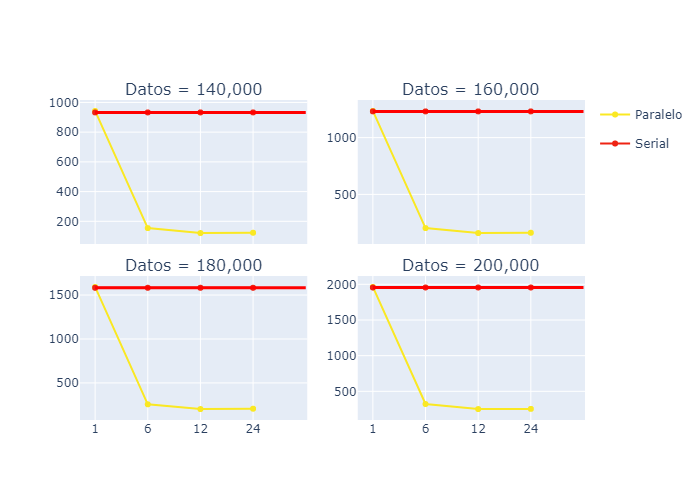

In [70]:
fig = make_subplots(rows=2, cols=2, vertical_spacing=0.1,
                    horizontal_spacing=0.1, shared_xaxes=True, shared_yaxes=False,subplot_titles=("Plot 1", "Plot 2", "Plot 3", "Plot 4"))

fig.add_trace(go.Scatter(x=hilos_arr, y=df.loc[(df['modo'] != 'serial') & (df['datos'] == "140000")].sort_index()['tiempo'], 
                         line_color='#fae823', showlegend=False,
                         hovertemplate=[], xaxis='x1', yaxis='y1',legendgroup = '1',name='Paralelo'), row=1, col=1)

fig.add_trace(go.Scatter(x=hilos_arr, y=df.loc[(df['modo'] != 'serial') & (df['datos'] == "160000")].sort_index()['tiempo'],
                         line_color='#fae823', showlegend=False,
                         hovertemplate=[], xaxis='x2', yaxis='y2',legendgroup = '1',name='Paralelo'), row=1, col=2)

fig.add_trace(go.Scatter(x=hilos_arr, y=df.loc[(df['modo'] != 'serial') & (df['datos'] == "180000")].sort_index()['tiempo'], 
                         line_color='#fae823', showlegend=True,
                         hovertemplate=[], xaxis='x3', yaxis='y3',legendgroup = '1',name='Paralelo'), row=2, col=1)

fig.add_trace(go.Scatter(x=hilos_arr, y=df.loc[(df['modo'] != 'serial') & (df['datos'] == "200000")].sort_index()['tiempo'],
                         line_color='#fae823', showlegend=False,
                         hovertemplate=[], xaxis='x4', yaxis='y4',legendgroup = '1',name='Paralelo'), row=2, col=2)

lista = ['140000','160000','180000','200000']
cont = 0
for i in range(2):
    for j in range(2):
            dt = df.loc[(df['modo'] == 'serial') & (df['datos'] == lista[cont])].sort_index()['tiempo'].sum()
            cont += 1
            if cont == 1:
                fig.add_trace(go.Scatter(x=hilos_arr, y=[dt,dt,dt,dt],
                         line_color='#EE2313', showlegend=True,
                         hovertemplate=[], xaxis='x' + str(cont), yaxis='y' + str(cont),legendgroup = '2',name='Serial'), row=i+1, col=j+1)
            else:
                fig.add_trace(go.Scatter(x=hilos_arr, y=[dt,dt,dt,dt],
                         line_color='#EE2313', showlegend=False,
                         hovertemplate=[], xaxis='x' + str(cont), yaxis='y' + str(cont),legendgroup = '2',name='Serial'), row=i+1, col=j+1)

names = {'Plot 1':'Datos = 140,000', 'Plot 2':'Datos = 160,000', 'Plot 3':'Datos = 180,000', 'Plot 4':'Datos = 200,000'}
fig.for_each_annotation(lambda a: a.update(text = names[a.text]))

# add shapes
col_count = 1
for i in range(1,3):
    for j in range(1,3):
        fig.add_shape(go.layout.Shape(type="line",
                                        yref="paper",
                                        xref="x",
                                        x0=0,
                                        y0=df.loc[(df['modo'] == 'serial') & (df['datos'] == lista[col_count-1])].sort_index()['tiempo'].sum(),
                                        x1=4,
                                        y1=df.loc[(df['modo'] == 'serial') & (df['datos'] == lista[col_count-1])].sort_index()['tiempo'].sum(),
                                        #line=dict(color="RoyalBlue", width=3),),
                                        line=dict(color='red', width=3),),
                      row=i,
                      col=j)
        col_count = col_count+1
fig.update_layout(legend_groupclick='toggleitem')

if interactive_graphs:
    fig.show()
else:
    fig.show("png")

## Conclusiones
Como se puede ver en todas las gráficas, la implementación paralelizada es mucho más rápida que la implementación serial. El único caso en el que es diferente, aunque por muy poco es cuando ejecutamos el programa con solo un hilo, si vemos las gráficas el algoritmo paralelizado con un hilo es un poco más tardado que el serial. Esto se debe al overhead que produce el hacer un programa paralelizado, usualmente este tiempo se suele “recuperar” al ocupar más de un hilo, pero si solo ocupamos uno, se pierde el punto. 
Otra cosa que conviene notar es que al correr el programa con el doble de hilos del que tenemos disponibles no hay ninguna diferencia que cuando lo corremos con el total de hilos disponibles. Las mediciones mostradas arriba fueron hechas con una computadora de 12 hilos lo que quiere decir que al correrlo con 12 y con 24 hilo no hay ninguna diferencia. 
